In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.1.0


# 1. Load Data

In [5]:
# overall_summary = pd.read_csv('overall_summary.csv')
overall_summary = pd.read_csv('CR.csv')
time = overall_summary['datetime_id']
time = time.to_numpy()[1:]
volume_series = overall_summary['CR_lag1']
volume_series = volume_series.to_numpy()[1:]
overall_summary

,Unnamed: 0,datetime_id,date_id,date,hour,volume_of_ISSR,CR_lag1
0,1,1,1,20200517,0,0.270592,NaN
1,2,2,1,20200517,1,0.231338,-0.156730
2,3,3,1,20200517,2,0.196750,-0.161946
3,4,4,1,20200517,3,0.208172,0.056431
4,5,5,1,20200517,4,0.228282,0.092214
...,...,...,...,...,...,...,...
5491,5492,5492,229,20201231,19,0.263514,-0.021142
5492,5493,5493,229,20201231,20,0.275740,0.045354
5493,5494,5494,229,20201231,21,0.370335,0.294948
5494,5495,5495,229,20201231,22,0.326577,-0.125743


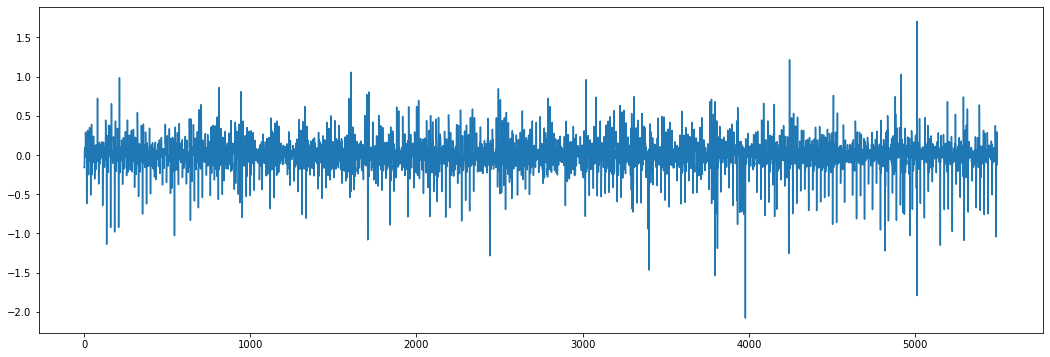

In [6]:
# overall_summary['volume_of_ISSR'].plot(figsize=(18,6));
overall_summary['CR_lag1'].plot(figsize=(18,6));

**Decompose Time-Series to see Individual Components (trend + seasonality + noise)**

https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas

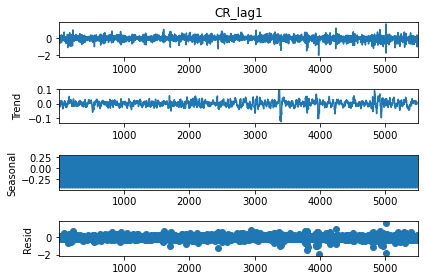

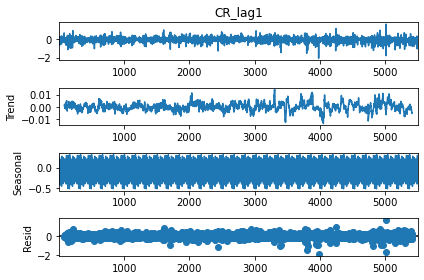

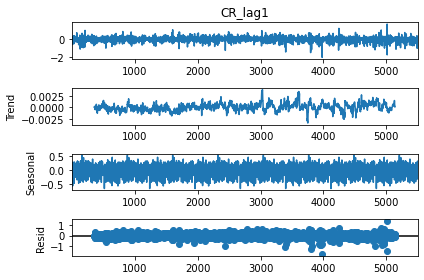

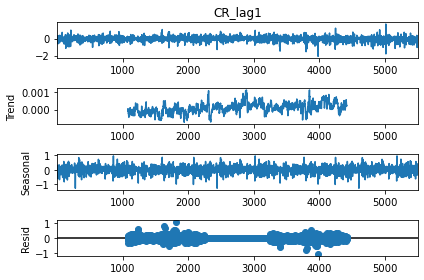

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result1 = seasonal_decompose(overall_summary['CR_lag1'][1:], period = 24, model="additive")
trend1 = decompose_result1.trend
seasonal1 = decompose_result1.seasonal
residual1 = decompose_result1.resid

decompose_result2 = seasonal_decompose(overall_summary['CR_lag1'][1:], period = 24*7, model="additive")
trend2 = decompose_result2.trend
seasonal2 = decompose_result2.seasonal
residual2 = decompose_result2.resid

decompose_result3 = seasonal_decompose(overall_summary['CR_lag1'][1:], period = 24*30, model="additive")
trend3 = decompose_result3.trend
seasonal3 = decompose_result3.seasonal
residual3 = decompose_result3.resid

decompose_result4 = seasonal_decompose(overall_summary['CR_lag1'][1:], period = 24*90, model="additive")
trend4 = decompose_result4.trend
seasonal4 = decompose_result4.seasonal
residual4 = decompose_result4.resid

decompose_result1.plot()
decompose_result2.plot()
decompose_result3.plot()
decompose_result4.plot();

**Dicky-Fuller Test for Stationarity**

- `p-value > 0.05`: This implies that time-series is non-stationary.
- `p-value <=0.05`: This implies that time-series is stationary.



In [8]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(overall_summary['CR_lag1'][1:], autolag = "BIC" )

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Method to use when automatically determining the lag length : ", 'BIC' )
print("5. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("6. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -17.146511613377744
2. P-Value :  6.988254322916931e-30
3. Num Of Lags :  23
4. Method to use when automatically determining the lag length :  BIC
5. Num Of Observations Used For ADF Regression and Critical Values Calculation : 5471
6. Critical Values :
	 1% :  -3.4315458272402592
	 5% :  -2.8620684363437117
	 10% :  -2.5670512855848058


**Conclusion:** 

- Our data tends to be non-stationary series and the period tends to be 1 year. But we only have data of past 8 months. It is hard to find the correct trend and seasonality.
- To predict on non-stationary time series, we could just train for limited period. And then, the data in limited period tends to be stationary series, just like what the Dicky-Fuller Test shows.
> To predict on non-stationary time series, **we could just train for limited period of time.** For example, here where I take just the last 100 steps. You'll probably get a better performance than if you had trained on the entire time series. But that's breaking the mold for typical machine, learning where we always assume that more data is better. But for time series forecasting it really depends on the time series. If it's stationary, meaning its behavior does not change over time, then great. The more data you have the better. But if it's not stationary then the optimal time window that you should use for training will vary.
- It is fine to directly use our dataset to train time series models without removing trend and seasonality.

# 2. Demo for LSTM Model

- split the data to training set and validate set with a proportion of around 50% (to limit the period of time)
- define some variables

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234) # Set the global random seed.
np.random.seed(1234)

split_time = 3000  # 1000, 2000, 3000, 4000 as a tuning parameter
time_train = time[:split_time]
x_train = volume_series[:split_time]
time_valid = time[split_time:]
x_valid = volume_series[split_time:]

window_size = 3
batch_size = 30
shuffle_buffer_size = 3000
model_index = 1

- Define functions for the creation of rolling windows and visualizations for final results.
- The output of rolling window function include both predictors and response variable

In [10]:
def windowed_dataset(series, model_index, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + model_index, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + model_index)) # Convert each window to numpy format
    dataset = dataset.shuffle(shuffle_buffer_size, seed = 123).map(lambda window: (window[:-model_index], window[-1])) # Shuffle data and Retrieve features and response variable
    dataset = dataset.batch(batch_size).prefetch(1) # Combines consecutive elements of this dataset into batches
    return dataset
def plot_series(time, series, title, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    plt.grid(True)

- Generate rolling windows
- Train the model

In [21]:
dataset = windowed_dataset(series = x_train, model_index = model_index, 
                           window_size = window_size, 
                           batch_size = batch_size, 
                           shuffle_buffer_size = shuffle_buffer_size)
print(dataset)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[None]),
                         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, 
                                                                            return_sequences=True, 
                                                                            activation = "tanh")),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, 
                                                     activation = "tanh")),
  tf.keras.layers.Dense(1, 
                        activation = "tanh"),
  tf.keras.layers.Lambda(lambda x: x * 2) # scale_layer

])

model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


- Make prediction for the entire timeline (from timestamp window_size+1 to timestamp 5496): **forecast**
- Retrieve the predicted value for test set: **results_valid**
- Retrieve the predicted value for train set: **results_train**

In [22]:
forecast = []

for timestamp in range(len(volume_series) - window_size- (model_index-1)):
    forecast.append(model.predict(volume_series[timestamp:timestamp + window_size][np.newaxis]))

# predicted value on validate set
forecast_valid = forecast[split_time-window_size-(model_index-1):]
results_valid = np.array(forecast_valid)[:, 0, 0]

# predicted value on training set
forecast_train = forecast[:split_time-window_size-(model_index-1)]
results_train = np.array(forecast_train)[:, 0, 0]

- Visualization

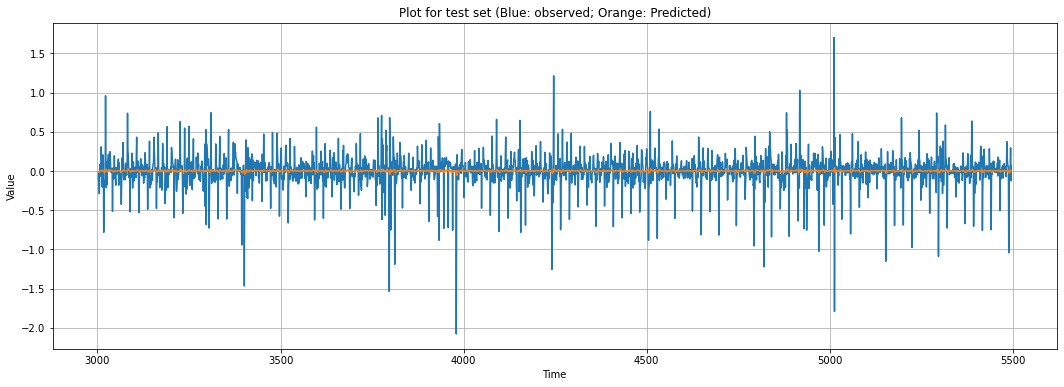

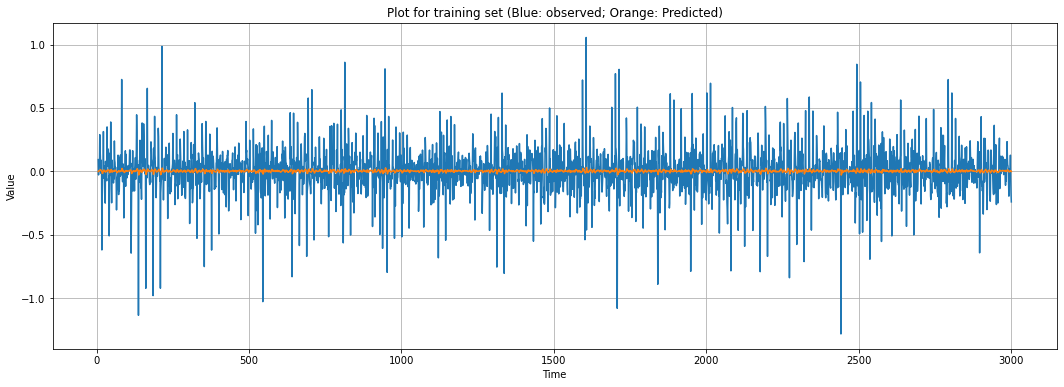

In [23]:
plt.figure(figsize=(18, 6))
plot_series(time_valid, x_valid, title = "Plot for test set (Blue: observed; Orange: Predicted)")
plot_series(time_valid, results_valid, title = "Plot for test set (Blue: observed; Orange: Predicted)");
# Blue: x_valid (observed); Orange: results_valid(predicted)

plt.figure(figsize=(18, 6))
plot_series(time_train[window_size+(model_index-1):], x_train[window_size+(model_index-1):], title = "Plot for training set (Blue: observed; Orange: Predicted)")
plot_series(time_train[window_size+(model_index-1):], results_train, title = "Plot for training set (Blue: observed; Orange: Predicted)");

- Performance

In [24]:
print("LSTM-MAE(test set) =", tf.keras.metrics.mean_absolute_error(x_valid, results_valid).numpy())
print("LSTM-MSE(test set) =", tf.keras.metrics.mean_squared_error(x_valid, results_valid).numpy())
print("LSTM-MAE(training set) =", tf.keras.metrics.mean_absolute_error(x_train[window_size+(model_index-1):], results_train).numpy())
print("LSTM-MSE(training set) =", tf.keras.metrics.mean_squared_error(x_train[window_size+(model_index-1):], results_train).numpy())

LSTM-MAE(test set) = 0.12214631
LSTM-MSE(test set) = 0.044192925
LSTM-MAE(training set) = 0.117492974
LSTM-MSE(training set) = 0.03164917


- Static Model Performance

In [25]:
print("Static-MAE(test set) =", tf.keras.metrics.mean_absolute_error(volume_series[3000:], volume_series[3000-model_index:-model_index]).numpy())
print("Static-MSE(test set) =", tf.keras.metrics.mean_squared_error(volume_series[3000:], volume_series[3000-model_index:-model_index]).numpy())

Static-MAE(test set) = 0.17419391584945354
Static-MSE(test set) = 0.0846990704155348
